# Deep Learning for NLP - Project

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "C:/Users/louis/Documents/Msc data science/Centrale/Deep Learning/nlp_project/data/"

# 1) Monolingual (English) word embeddings 

In [3]:
# Word to vec class
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        print(fname)
        with io.open(fname, encoding='utf-8') as f:
            next(f)
           
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                #print(word)
                word=word.lower()
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        self.list_score=[]
        w=w.lower()
        #self.list_sorted=[]
        for word in self.word2vec:
            self.list_score.append((self.score(word,w),word))
        self.list_sorted=sorted(self.list_score,key=lambda x:x[0],reverse=True)
        return (self.list_sorted[1:K+1]) #get rid of itself because similarity is 1

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        #conversion to lower case
        w1=w1.lower()
        w2=w2.lower()
        #get vector coordinates for the words
        word1=self.word2vec[w1]
        word2=self.word2vec[w2]
        s=np.dot(word1,word2)/(np.linalg.norm(word1)*np.linalg.norm(word2))
        return(s)


In [4]:
# evaluation 
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))


C:/Users/louis/Documents/Msc data science/Centrale/Deep Learning/nlp_project/data/crawl-300d-200k.vec
Loaded 19765 pretrained word vectors
cat dog 0.2510936879670139
dog pet 0.28149744895768625
dogs cats 0.6747577573530962
paris france 0.7058595452409975
germany berlin 0.7060253015336013
[(0.45469832732644455, 'man'), (0.4538155159290066, 'sat'), (0.4385987708786815, 'pet'), (0.40771665960864695, 'act'), (0.4010274360865279, 'star')]
[(0.7660710966826116, 'dogs'), (0.6288435326377401, 'puppy'), (0.5786290691941408, 'canine'), (0.5716627372454851, 'horse'), (0.5613438419954163, 'pets')]
[(0.7660710966826116, 'dog'), (0.7146502694918196, 'pets'), (0.6747577573530962, 'cats'), (0.5817275228710577, 'animals'), (0.5503549152271858, 'horses')]
[(0.7325631347775841, 'parisian'), (0.7058595452409975, 'france'), (0.6135319861170939, 'versailles'), (0.609683784465089, 'lyon'), (0.5787746712318416, 'bordeaux')]
[(0.7173178955997039, 'austria'), (0.7163809202373845, 'bavaria'), (0.7060253015336013

In [5]:
#Bag of words class
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # --------------------------------------------------------------------------------- 
        sentemb = []
        embedding_vec = np.zeros(300)
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                embedding_vec = sum([self.w2v.word2vec.get(words, np.zeros(300)) for words in sent])/len(sent)
                sentemb.append(embedding_vec/len(sent))
            else:
                # idf-weighted mean of word vectors
                embedding_vec = sum([self.w2v.word2vec.get(words, np.zeros(300))*self.idf_dic[words] for words in sent])/len(sent)
                sentemb.append(embedding_vec)
        # --------------------------------------------------------------------------------- 
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        # --------------------------------------------------------------------------------- 
        if idf == False:
            keys = self.encode(sentences)
            query = self.encode([s])
        else:
            keys = self.encode(sentences, idf)
            query = self.encode([s], idf)
        
        # build an np.array where column 0 is index, column 1 is corresponding score, 
        # score has been set to 0 for score(s1, s2), where s1 = s2 -> aviod to output itself as the most similar sentence
        sent_score_list = np.array( [ [index, 0] if (s1==query).all() else [index, self.score(query, s1, s_is_vec=True)] for index, s1 in enumerate(keys) ] )
        K_similar_sents_list = [ sentences[np.argsort(sent_score_list[:,1], axis=0)[-i-1]]   for i in range(K) ] 
        
        for sent in K_similar_sents_list:
            print(" ".join(sent))
        #---------------------------------------------------------------------------------       
        return

    def score(self, s1, s2, idf=False, s_is_vec=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm      
        # ---------------------------------------------------------------------------------
        if s_is_vec == False:
            if idf == False:
                vec1 = self.encode([s1])
                vec2 = self.encode([s2])
            else:
                vec1 = self.encode([s1], idf)
                vec2 = self.encode([s2], idf)
        else:
            vec1 = s1
            vec2 = s2           
        cos_similarity = np.dot(vec1, vec2.T)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
        # ---------------------------------------------------------------------------------             
        return cos_similarity
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # --------------------------------------------------------------------------------- 
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        self.idf_dic = { word: max(1, np.log10(len(sentences) / (idf[word]))) for word, value in idf.items() }
        # --------------------------------------------------------------------------------- 
        return self.idf_dic


In [6]:
# Evaluation BoV
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
# --------------------------------------------------------------------------------- 
sentences = []
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        sentence_split = line.split(' ')
        sentences.append([t.lower() for t in sentence_split])
# --------------------------------------------------------------------------------- 

# Build idf scores for each word

s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print('Most similar to :', " ".join(sentences[10]))
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

idf = {}  
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

C:/Users/louis/Documents/Msc data science/Centrale/Deep Learning/nlp_project/data/crawl-300d-200k.vec
Loaded 19765 pretrained word vectors
Most similar to : 1 woman in a black jacket is drinking out of a bottle while others are smiling . 

a woman in a blue shirt is laughing with a woman in a black shirt outside , as people are sitting and standing all around them . 

a woman with blond-hair is drinking out of a glass . 

a young woman in a gray and black shirt is sitting by a tree , drinking something out of a paper cup with a straw . 

a man in a pink shirt and a woman in a teal shirt , who is drinking wine , are sitting in a dark corner and talking . 

a man in a blue shirt carrying a backpack and a woman dressed in black holding some type of box are deep in conversation . 

[[0.81265467]]
a man in a white shirt squirting a bottle of a drink and smiling . 

a bicyclist is drinking out of a bottle of water while riding . 

a woman in a red shirt standing next to a woman in a black sh

# 2) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# Create classes 
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000) 
s2v = BoV(w2v)

#Load data
SST='C:/Users/louis/Documents/Msc data science/Centrale/Deep Learning/nlp_project/data/SST/'
labels=[]
train=[]
with open(os.path.join(SST, 'stsa.fine.train')) as f:
    for line in f:
        labels.append(int(line[0])) #get class
        train.append(line[1:len(line)-1]) #get sentence

dev=[]
labels_dev=[]
with open(os.path.join(SST, 'stsa.fine.dev')) as f:
    for line in f:
        labels_dev.append(int(line[0])) #get class
        dev.append(line[1:len(line)-1]) #get sentence
        
test=[]
with open(os.path.join(SST, 'stsa.fine.test.x')) as f:
    for line in f:
        test.append(line) #get sentence

combined=train+test


C:/Users/louis/Documents/Msc data science/Centrale/Deep Learning/nlp_project/data/crawl-300d-200k.vec
Loaded 19765 pretrained word vectors
1101


In [12]:
# 2 - Encode sentences with the BoV model above
from sklearn.preprocessing import normalize

s2v.build_idf(combined)
matrix=s2v.encode(combined)

train_vect=matrix[:len(train)]
test_vect=matrix[len(train):]

#normalize vector of train and test set
tt=normalize(train_vect)
ttest=normalize(test_vect)
print(tt)

[[-0.00647606  0.11966672 -0.04429934 ... -0.02959958 -0.09337698
  -0.01011749]
 [-0.0030643   0.12825755 -0.04785066 ... -0.02995261 -0.07599389
  -0.01728696]
 [-0.01664969  0.136322   -0.04695538 ... -0.03429115 -0.08546657
  -0.0297297 ]
 ...
 [-0.00902534  0.16262966 -0.05367443 ... -0.036827   -0.07836752
  -0.02441586]
 [-0.01588489  0.08665783 -0.04534149 ... -0.00799552 -0.07143226
  -0.02260761]
 [-0.0195598   0.1220789  -0.0438411  ... -0.02901052 -0.07855926
  -0.01623222]]


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

#split set into training and test set 80/20%
data_train , data_test , labels_train , labels_test = train_test_split(tt, labels , test_size =0.8 , random_state=42)
#print(labels_train)
clf = LogisticRegression(random_state=0, solver='sag',multi_class='multinomial').fit(data_train, labels_train)
labels_predicted=clf.predict(data_test)


#print(len(labels_predicted),len(labels_test))
print (classification_report(labels_test , labels_predicted ))

# TYPE CODE HERE

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       895
           1       0.30      0.23      0.26      1784
           2       0.32      0.00      0.01      1276
           3       0.28      0.82      0.42      1851
           4       0.08      0.00      0.00      1030

   micro avg       0.28      0.28      0.28      6836
   macro avg       0.20      0.21      0.14      6836
weighted avg       0.23      0.28      0.18      6836



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
output=clf.predict(ttest)
np.savetxt("logreg_bov_y_test_sst.txt",output)


In [15]:
# Improving performances with another classifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
clf4=BernoulliNB()
scores4=clf4.fit(data_train,labels_train)
labels_predicted4=clf4.predict(data_test)
print( classification_report(labels_test,labels_predicted4))

clf2 = svm.LinearSVC(C=1)

score = clf2.fit(data_train,labels_train)
labels_predicted2=clf2.predict(data_test)
print (classification_report(labels_test , labels_predicted2 ))

#Random forest
clf3=RandomForestClassifier(n_estimators=1000, max_depth=25,random_state=0)
score3 = clf3.fit(data_train,labels_train)
labels_predicted3=clf3.predict(data_test)
print (classification_report(labels_test , labels_predicted3 ))

#Save text file
output2=clf2.predict(ttest)
np.savetxt("svm_bov_y_test_sst.txt",output2)

              precision    recall  f1-score   support

           0       0.15      0.05      0.08       895
           1       0.28      0.44      0.34      1784
           2       0.26      0.10      0.14      1276
           3       0.29      0.33      0.31      1851
           4       0.21      0.23      0.22      1030

   micro avg       0.26      0.26      0.26      6836
   macro avg       0.24      0.23      0.22      6836
weighted avg       0.25      0.26      0.24      6836

              precision    recall  f1-score   support

           0       0.12      0.00      0.00       895
           1       0.30      0.42      0.35      1784
           2       0.29      0.06      0.10      1276
           3       0.29      0.61      0.39      1851
           4       0.23      0.02      0.03      1030

   micro avg       0.29      0.29      0.29      6836
   macro avg       0.25      0.22      0.17      6836
weighted avg       0.26      0.29      0.22      6836

              precisio

# 3) Sentence classification with LSTMs in Keras

## 3.1 - Preprocessing

In [16]:
import keras

Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
SST='C:/Users/louis/Documents/Msc data science/Centrale/Deep Learning/nlp_project/data/SST/'


from keras.utils import np_utils
labels=[]
train=[]
with open(os.path.join(SST, 'stsa.fine.train')) as f:
    for line in f:
        labels.append(int(line[0])) #get class
        train.append(line[1:len(line)-1]) #get sentence
y_train = np_utils.to_categorical(labels, 5)         
n_train=len(y_train)    

dev=[]
labels_dev=[]
with open(os.path.join(SST, 'stsa.fine.dev')) as f:
    for line in f:
        labels_dev.append(int(line[0])) #get class
        dev.append(line[1:len(line)-1]) #get sentence
y_dev = np_utils.to_categorical(labels_dev, 5)  
n_dev= len(y_dev)

combined=train+dev
test=[]
with open(os.path.join(SST, 'stsa.fine.test.x')) as f:
    for line in f:
        test.append(line) #get sentence



In [18]:
# 2 - Transform text to integers

from keras.preprocessing.text import Tokenizer
#getsize of vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)#train
n= len(tokenizer.word_index)+1
#print(vocab_size)

#preprocess the data using keras one_hot encoding function
def onehot(text,n):
    L=[]
    for sent in text:
        L.append(keras.preprocessing.text.one_hot(sent,n,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' '))
    return L

#get train, dev and test set
transformed_train=onehot(train,n)
transformed_dev=onehot(dev,n)
transformed_test=onehot(test,n)


In [19]:
# 3 - Padding sentences
x_train=keras.preprocessing.sequence.pad_sequences(transformed_train, maxlen=53, dtype='int32', padding='pre', truncating='pre', value=0.0)
x_dev=keras.preprocessing.sequence.pad_sequences(transformed_dev, maxlen=53, dtype='int32', padding='pre', truncating='pre', value=0.0)
x_test=keras.preprocessing.sequence.pad_sequences(transformed_test, maxlen=53, dtype='int32', padding='pre', truncating='pre', value=0.0)
print(x_train.shape,x_dev.shape,x_test.shape)



(8544, 53) (1101, 53) (2210, 53)


## 3.2 - Design and train your model

In [20]:
# 4 - Design encoder + classifier using keras



from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 50  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = n  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='softmax'))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`


In [21]:
# 5 - Definingloss/optimizer/metrics


loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          766900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 859,193
Trainable params: 859,193
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# 6 - Traininig  model and finding the best hyperparameters for your dev set

import matplotlib.pyplot as plt

bs = 64
epochs = 6

history = model.fit(x_train, y_train, batch_size=bs, epochs=epochs, validation_data=(x_dev, y_dev))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 25s 3ms/step - loss: 1.5615 - acc: 0.2925 - val_loss: 1.4907 - val_acc: 0.3479
Epoch 2/6
8544/8544 [==============================] - 24s 3ms/step - loss: 1.3520 - acc: 0.4184 - val_loss: 1.3915 - val_acc: 0.3887
Epoch 3/6
8544/8544 [==============================] - 23s 3ms/step - loss: 1.0885 - acc: 0.5480 - val_loss: 1.4486 - val_acc: 0.3760
Epoch 4/6
8544/8544 [==============================] - 24s 3ms/step - loss: 0.8533 - acc: 0.6675 - val_loss: 1.6175 - val_acc: 0.3597
Epoch 5/6
8544/8544 [==============================] - 24s 3ms/step - loss: 0.6540 - acc: 0.7555 - val_loss: 1.9621 - val_acc: 0.3624
Epoch 6/6
8544/8544 [==============================] - 23s 3ms/step - loss: 0.5052 - acc: 0.8208 - val_loss: 2.1492 - val_acc: 0.3542


<Figure size 640x480 with 1 Axes>

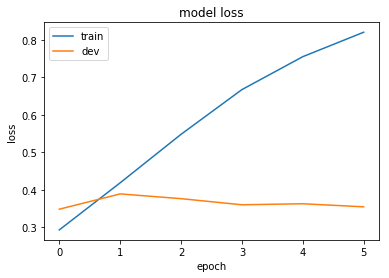

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [24]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.


output3=[]
pred=model.predict(x_test)
for i in pred:
    output3.append(np.argmax(i))

print(output3)
np.savetxt("logreg_lstm_y_test_sst.txt",output3)

[1, 3, 3, 2, 1, 2, 3, 4, 3, 1, 2, 3, 1, 3, 0, 1, 2, 1, 3, 3, 1, 0, 3, 3, 4, 1, 1, 3, 1, 3, 1, 1, 2, 1, 3, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 2, 0, 2, 3, 3, 1, 1, 3, 3, 3, 1, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 2, 1, 2, 2, 2, 1, 1, 3, 2, 0, 3, 3, 0, 3, 1, 1, 2, 2, 1, 1, 2, 2, 3, 3, 1, 2, 4, 3, 3, 3, 1, 2, 3, 3, 3, 1, 1, 3, 3, 2, 1, 4, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 2, 3, 2, 3, 0, 3, 0, 0, 1, 3, 1, 3, 1, 3, 1, 3, 2, 1, 2, 3, 1, 2, 1, 2, 3, 1, 3, 2, 1, 3, 2, 1, 3, 4, 2, 3, 3, 1, 1, 3, 1, 3, 3, 2, 1, 2, 3, 3, 1, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 4, 2, 3, 2, 3, 2, 2, 4, 0, 2, 2, 2, 3, 3, 3, 0, 2, 3, 2, 4, 2, 1, 3, 0, 4, 1, 1, 2, 1, 1, 3, 2, 3, 2, 3, 3, 3, 3, 3, 0, 3, 2, 3, 2, 3, 2, 2, 1, 1, 3, 3, 4, 3, 3, 3, 1, 2, 0, 4, 2, 2, 1, 1, 1, 3, 2, 1, 2, 3, 2, 3, 3, 1, 1, 1, 1, 3, 3, 4, 3, 1, 3, 2, 4, 3, 2, 3, 4, 3, 1, 3, 3, 4, 0, 3, 2, 3, 1, 3, 1, 2, 3, 1, 3, 1, 3, 3, 3, 2, 3, 1, 1, 2, 3, 3, 0, 3, 4, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 0, 3, 1, 1, 1, 3, 3, 2, 4, 1, 2, 

## 3.3 -- innovate !

(8544, 53, 1)
(1101, 53, 1)
15338
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 53, 100)           200       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 53, 100)           10100     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 17, 100)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 100)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1700)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 8505      
Total params: 18,805
Trainable params: 18,805
Non-trainable params: 0
______________________________________

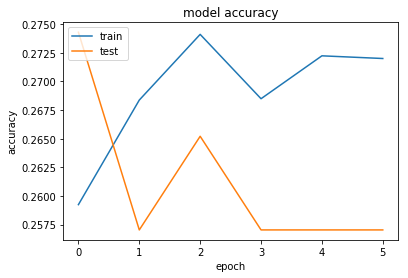

In [34]:
# 8 - Open question: find a model that is better on your dev set

from keras.layers.convolutional import Conv1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPooling1D
x_train2= np.expand_dims(x_train, axis=2) 
x_test2=np.expand_dims(x_test, axis=2) 

print(x_train2.shape)
x_dev2=np.expand_dims(x_dev, axis=2)
print(x_dev2.shape)
# TYPE CODE HERE
model_m=Sequential()
print(vocab_size)


model_m.add(Conv1D(100, 1, activation='relu', input_shape=(53,1)))
model_m.add(Conv1D(100, 1, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Dropout(0.5))
model_m.add(Flatten())
model_m.add(Dense(5, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']


model_m.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model_m.summary())
bs = 64
epochs = 6

history = model_m.fit(x_train2, y_train, batch_size=bs, epochs=epochs, validation_data=(x_dev2, y_dev))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
output4=[]
pred2=model_m.predict(x_test2)
for i in pred:
    output4.append(np.argmax(i))

np.savetxt("conv1D_2layers_y_test_sst.txt",output4)